# Adjusting for class imbalance (more no flood than flood pixels in binary mask)


In [4]:
import tensorflow as tf
import numpy as np
import tifffile as tiff
import os
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import keras.backend as K
import tensorflow as tf

import glob
import cv2


# Load TIFF images correctly
def load_image(image_path):
    try:
        image = tiff.imread(image_path)  # Use tifffile instead of OpenCV
        if image is None:
            print(f" Failed to load image: {image_path}")
        return image
    except Exception as e:
        print(f" Error loading image {image_path}: {e}")
        return None

# Load masks correctly
def load_mask(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
    if mask is None:
        print(f" Failed to load mask: {mask_path}")
    else:
        mask = mask.astype(np.float32) / 255.0  # Normalize to 0-1
    return mask

# Adjust paths to correctly get images and masks
image_paths = sorted(glob.glob("/kaggle/input/satalite1/satalite data/data/images/*.tif"))  # TIFF images
mask_paths = sorted(glob.glob("/kaggle/input/satalite1/satalite data/data/labels/*.png"))  # PNG masks

print("Type of mask_paths:", type(mask_paths))
print("First mask path:", mask_paths[0] if isinstance(mask_paths, list) else mask_paths)

# Debugging: Check number of files
print(f"Found {len(image_paths)} image files")
print(f"Found {len(mask_paths)} mask files")

image_names = {p.split("/")[-1].split(".")[0] for p in image_paths}
mask_names = {p.split("/")[-1].split(".")[0] for p in mask_paths}
print("Images missing masks:", image_names - mask_names)
print("Masks missing images:", mask_names - image_names)
mask_paths_filtered = [p for p in mask_paths if p.split("/")[-1].split(".")[0] in image_names]
mask = np.array([load_mask(p) for p in mask_paths_filtered])

# Debugging: Check number of matched files
print(f"After filtering, {len(image_paths)} image files and {len(mask_paths_filtered)} mask files remain.")

# Load the images and masks
X_train = np.array([load_image(p) for p in image_paths])
Y_train = np.array([load_mask(p) for p in mask_paths_filtered])  # Use filtered masks
Y_train = (Y_train > 0).astype(np.uint8)  # Convert to 0s and 1s

# Expand dims if grayscale
if len(X_train.shape) == 3:  # (num_samples, height, width)
    X_train = np.expand_dims(X_train, axis=-1)  # (num_samples, height, width, 1)
    Y_train = np.expand_dims(Y_train, axis=-1)  # (num_samples, height, width, 1)

Y_train = np.expand_dims(Y_train, axis=-1)  # Shape becomes (306, 128, 128, 1)
print("Unique values in Y_train:", np.unique(Y_train))


# U-Net Model Definition
def unet_model(input_shape=(128, 128, 12)): 
    inputs = Input(input_shape)

    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    u5 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)  # Binary segmentation

    model = Model(inputs, outputs)
    return model


def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    
    iou = (intersection + smooth) / (union + smooth)
    return iou


class IoUCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        print(f"\nEpoch {epoch+1}: IoU = {logs.get('iou_metric'):.4f}")


# Count flood (1s) vs. non-flood (0s)
flood_pixels = np.sum(Y_train == 1)
non_flood_pixels = np.sum(Y_train == 0)

print(f"Flood Pixels: {flood_pixels}, Non-Flood Pixels: {non_flood_pixels}")
print(f"Flood Coverage: {flood_pixels / (flood_pixels + non_flood_pixels):.4f}")

Type of mask_paths: <class 'list'>
First mask path: /kaggle/input/satalite1/satalite data/data/labels/0.png
Found 306 image files
Found 456 mask files
Images missing masks: set()
Masks missing images: {'110_287', '101_89', '49_64', '15_233', '134_153', '148_297', '103_225', '107_59', '108_236', '52_160', '25_172', '98_253', '3_74', '117_97', '37_118', '93_217', '65_203', '63_17', '115_49', '90_303', '62_187', '74_65', '146_84', '95_221', '44_191', '128_294', '26_274', '87_182', '104_20', '121_142', '79_161', '125_201', '47_15', '132_126', '123_145', '124_95', '4_300', '94_119', '149_166', '57_45', '61_206', '150_243', '2_215', '137_140', '10_244', '83_131', '28_2', '24_111', '81_9', '88_157', '5_275', '114_220', '120_305', '29_186', '67_156', '68_180', '75_52', '77_61', '59_132', '13_234', '71_120', '21_254', '22_16', '73_23', '60_245', '140_34', '142_238', '139_108', '51_91', '66_22', '96_154', '20_283', '131_185', '80_124', '97_130', '39_27', '145_164', '42_281', '11_116', '36_240', 

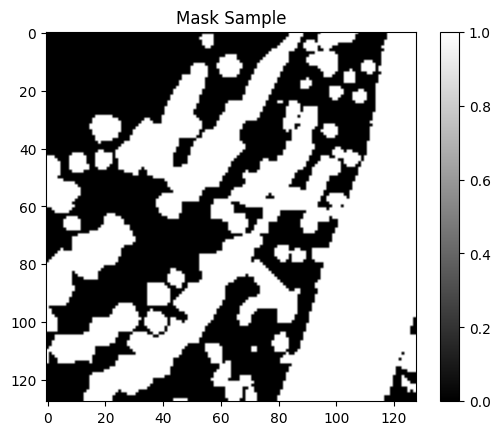

In [12]:
import matplotlib.pyplot as plt

idx = np.random.randint(0, len(Y_train))  # Pick a random sample
plt.imshow(Y_train[idx], cmap="gray")
plt.title("Mask Sample")
plt.colorbar()
plt.show()


In [5]:
import torch

# Pixel counts
num_flood = 1302272
num_non_flood = 3711232
total_pixels = num_flood + num_non_flood

# Compute weights
weight_flood = total_pixels / (2 * num_flood)
weight_non_flood = total_pixels / (2 * num_non_flood)

# Convert to tensor for loss function
class_weights = torch.tensor([weight_non_flood, weight_flood], dtype=torch.float32).to("cuda")  # Use "cuda" if on GPU

print(class_weights)


tensor([0.6755, 1.9249], device='cuda:0')


In [7]:
def dice_loss(y_true, y_pred, weights):
    smooth = 1e-5
    y_pred = tf.keras.activations.sigmoid(y_pred)  # Ensure predictions are between 0 and 1

    # Flatten tensors for dice coefficient calculation
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    dice = (2.0 * intersection + smooth) / (tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + smooth)

    # Apply class weights (assuming binary segmentation)
    class_weights = tf.gather(weights, tf.cast(y_true_flat, tf.int32))  # Get weights for each pixel
    weighted_dice_loss = (1 - dice) * tf.reduce_mean(class_weights)

    return weighted_dice_loss


flood_weight = 1 / 0.2598  # ~3.85
non_flood_weight = 1 / 0.7402  # ~1.35
class_weights = tf.constant([non_flood_weight, flood_weight])  # Background=0, Flood=1


In [8]:
# Set input shape based on your dataset
input_shape = X_train.shape[1:]  # (height, width, channels)

# Initialize model
model = unet_model(input_shape)

# Compile model
#model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_loss, metrics=[iou_metric])
# Compile U-Net model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=lambda y_true, y_pred: dice_loss(y_true, y_pred, class_weights),  
    metrics=[iou_metric]
)

# Print summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 12)   │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          6,976 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 32, 32, 256)    │        524,544 │ conv2d_7[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 512)    │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 32, 32, 256)    │      1,179,904 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 64, 64, 128)    │        131,200 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)    

 Total params: 7,702,529 (29.38 MB)

 Trainable params: 7,702,529 (29.38 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Define training parameters
batch_size = 8
epochs = 20

# Train the model
history = model.fit(
    X_train, Y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=[IoUCallback()]
)

# Save the trained model
model.save("unet_model.keras")


Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - iou_metric: 0.2503 - loss: 1.2324
Epoch 1: IoU = 0.2764
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 407ms/step - iou_metric: 0.2511 - loss: 1.2319 - val_iou_metric: 0.2634 - val_loss: 1.2268
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - iou_metric: 0.3046 - loss: 1.2102
Epoch 2: IoU = 0.3662
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - iou_metric: 0.3065 - loss: 1.2095 - val_iou_metric: 0.5281 - val_loss: 1.1873
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - iou_metric: 0.6317 - loss: 1.1499
Epoch 3: IoU = 0.6138
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - iou_metric: 0.6312 - loss: 1.1498 - val_iou_metric: 0.5946 - val_loss: 1.1600
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - iou_metric: 0.6349 - loss: 1.1236
Epoch 4: IoU = 0.6045
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - iou_metric: 0.6339 - loss: 1.1241 - val_iou_metric: 0.6242 - val_loss: 1.1606
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - iou_metric: 0.5589 - loss: 1

/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:     loss=lambda y_true, y_pred: dice_loss(y_true, y_pred, class_weights),  

  return {key: serialize_keras_object(value) for key, value in obj.items()}


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


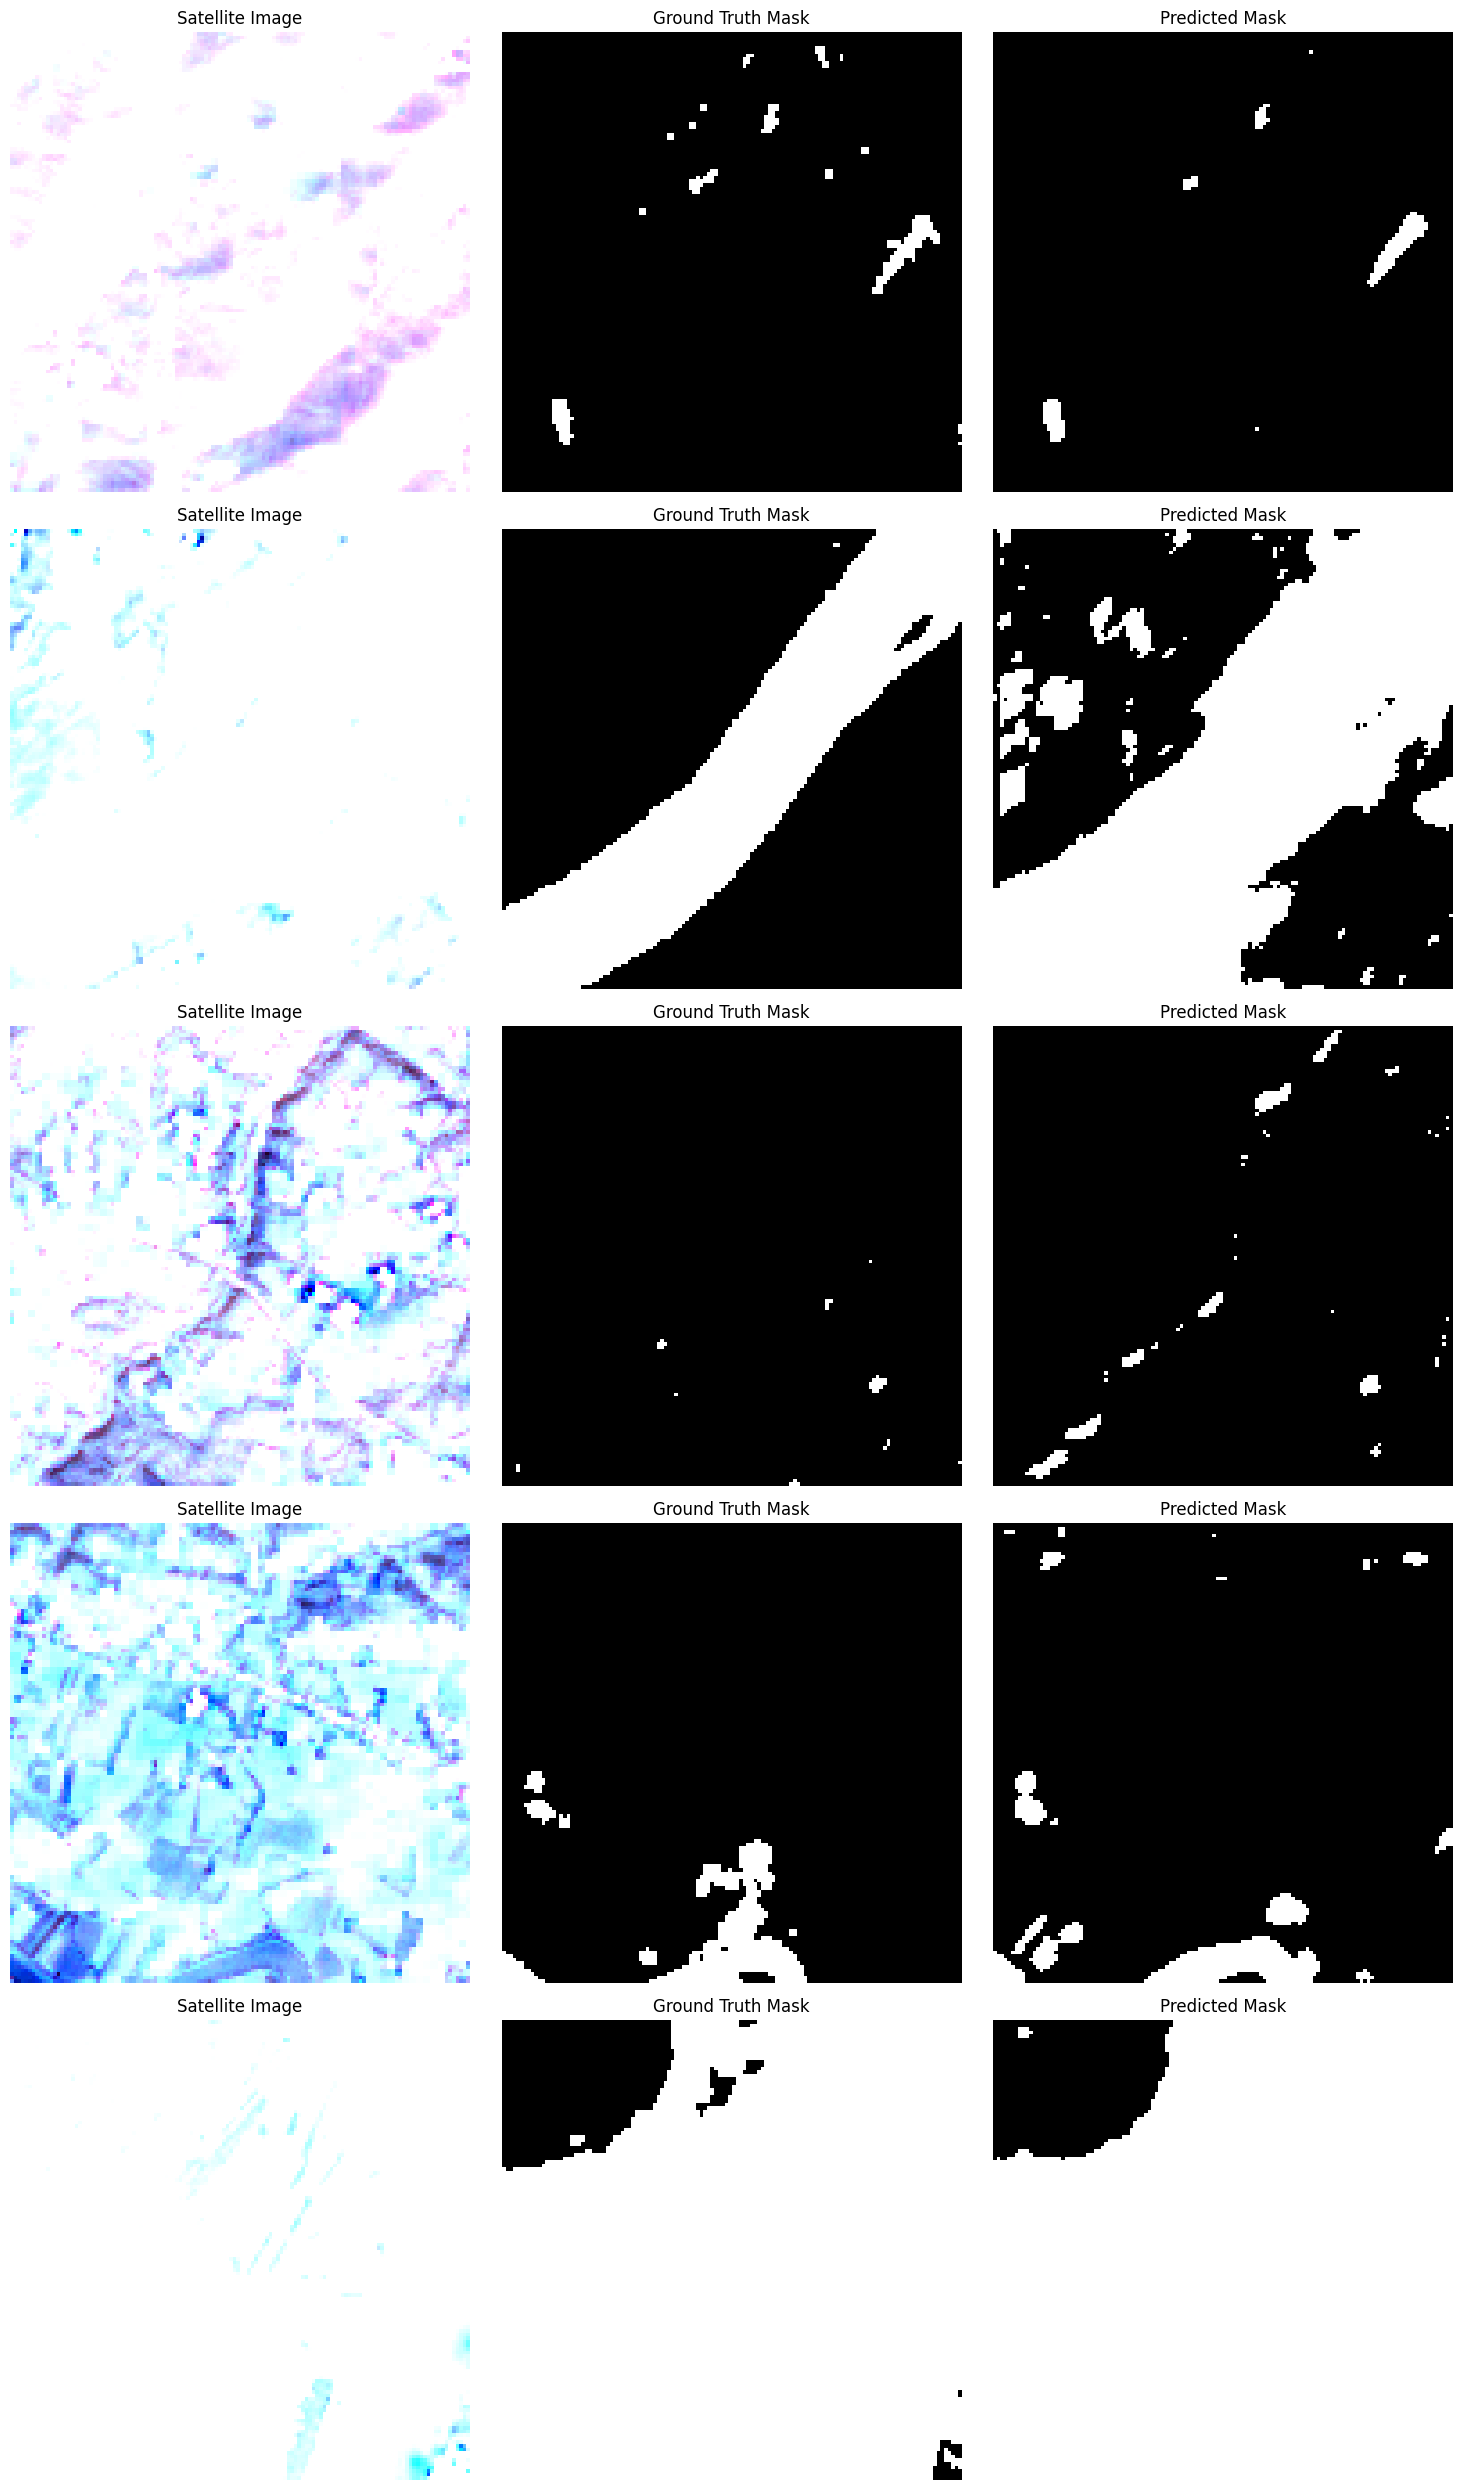

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def show_predictions(model, X, Y, num_samples=5, threshold=0.5):
    indices = np.random.choice(len(X), num_samples, replace=False)
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

    for i, idx in enumerate(indices):
        image = X[idx]
        true_mask = Y[idx]

        # Predict flood mask using the trained model
        pred_mask = model.predict(image[np.newaxis, ...])  # Add batch dimension
        pred_mask = pred_mask.squeeze()  # Remove extra dimensions

        # Threshold to get binary mask (if needed)
        pred_mask = (pred_mask > threshold).astype(np.uint8)

        # Show satellite image
        axes[i, 0].imshow(image[:, :, :3])  # First 3 channels as RGB
        axes[i, 0].set_title("Satellite Image")
        axes[i, 0].axis("off")

        # Show ground truth mask
        axes[i, 1].imshow(true_mask.squeeze(), cmap="gray")
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis("off")

        # Show predicted mask
        axes[i, 2].imshow(pred_mask, cmap="gray")
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

# Call function
show_predictions(model, X_train, Y_train)


# Now adding BatchNormalization and Dropout(0.3)

In [2]:
import tensorflow as tf
import numpy as np
import tifffile as tiff
import os
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import keras.backend as K
from tensorflow.keras.layers import BatchNormalization, Dropout


import glob
import cv2


# Load TIFF images correctly
def load_image(image_path):
    try:
        image = tiff.imread(image_path)  # Use tifffile instead of OpenCV
        if image is None:
            print(f" Failed to load image: {image_path}")
        return image
    except Exception as e:
        print(f" Error loading image {image_path}: {e}")
        return None

# Load masks correctly
def load_mask(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
    if mask is None:
        print(f" Failed to load mask: {mask_path}")
    else:
        mask = mask.astype(np.float32) / 255.0  # Normalize to 0-1
    return mask

# Adjust paths to correctly get images and masks
image_paths = sorted(glob.glob("/kaggle/input/satalite1/satalite data/data/images/*.tif"))  # TIFF images
mask_paths = sorted(glob.glob("/kaggle/input/satalite1/satalite data/data/labels/*.png"))  # PNG masks

print("Type of mask_paths:", type(mask_paths))
print("First mask path:", mask_paths[0] if isinstance(mask_paths, list) else mask_paths)

# Debugging: Check number of files
print(f"Found {len(image_paths)} image files")
print(f"Found {len(mask_paths)} mask files")

image_names = {p.split("/")[-1].split(".")[0] for p in image_paths}
mask_names = {p.split("/")[-1].split(".")[0] for p in mask_paths}
print("Images missing masks:", image_names - mask_names)
print("Masks missing images:", mask_names - image_names)
mask_paths_filtered = [p for p in mask_paths if p.split("/")[-1].split(".")[0] in image_names]
mask = np.array([load_mask(p) for p in mask_paths_filtered])

# Debugging: Check number of matched files
print(f"After filtering, {len(image_paths)} image files and {len(mask_paths_filtered)} mask files remain.")

# Load the images and masks
X_train = np.array([load_image(p) for p in image_paths])
Y_train = np.array([load_mask(p) for p in mask_paths_filtered])  # Use filtered masks
Y_train = (Y_train > 0).astype(np.uint8)  # Convert to 0s and 1s

# Expand dims if grayscale
if len(X_train.shape) == 3:  # (num_samples, height, width)
    X_train = np.expand_dims(X_train, axis=-1)  # (num_samples, height, width, 1)
    Y_train = np.expand_dims(Y_train, axis=-1)  # (num_samples, height, width, 1)

Y_train = np.expand_dims(Y_train, axis=-1)  # Shape becomes (306, 128, 128, 1)
print("Unique values in Y_train:", np.unique(Y_train))


def unet_model(input_shape=(128, 128, 12), learning_rate=0.0001):  
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)  # Batch Norm
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.3)(p1)  # Dropout

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.3)(p2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.3)(p3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    c4 = BatchNormalization()(c4)

    # Decoder
    u5 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)
    c5 = BatchNormalization()(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)
    c6 = BatchNormalization()(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    # Output Layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)  

    # Define Model
    model = Model(inputs, outputs)

    # Optimizer with Learning Rate
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[iou_metric])

    return model


def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    
    iou = (intersection + smooth) / (union + smooth)
    return iou


class IoUCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        print(f"\nEpoch {epoch+1}: IoU = {logs.get('iou_metric'):.4f}")


# Count flood (1s) vs. non-flood (0s)
flood_pixels = np.sum(Y_train == 1)
non_flood_pixels = np.sum(Y_train == 0)

print(f"Flood Pixels: {flood_pixels}, Non-Flood Pixels: {non_flood_pixels}")
print(f"Flood Coverage: {flood_pixels / (flood_pixels + non_flood_pixels):.4f}")

Type of mask_paths: <class 'list'>
First mask path: /kaggle/input/satalite1/satalite data/data/labels/0.png
Found 306 image files
Found 456 mask files
Images missing masks: set()
Masks missing images: {'57_45', '84_76', '14_135', '53_43', '91_102', '100_184', '121_142', '4_300', '23_251', '3_74', '116_250', '95_221', '147_213', '86_288', '98_253', '2_215', '58_114', '77_61', '47_15', '64_86', '22_16', '27_290', '37_118', '133_224', '11_116', '93_217', '12_286', '48_12', '141_237', '50_263', '131_185', '5_275', '70_268', '40_277', '128_294', '51_91', '129_177', '126_110', '72_205', '6_248', '65_203', '139_108', '74_65', '75_52', '25_172', '150_243', '99_170', '108_236', '21_254', '32_11', '59_132', '24_111', '114_220', '76_92', '111_121', '85_117', '39_27', '26_274', '20_283', '145_164', '132_126', '79_161', '44_191', '30_143', '46_55', '137_140', '52_160', '127_54', '110_287', '97_130', '82_100', '66_22', '19_293', '31_196', '43_149', '35_30', '92_272', '13_234', '9_202', '8_73', '125_

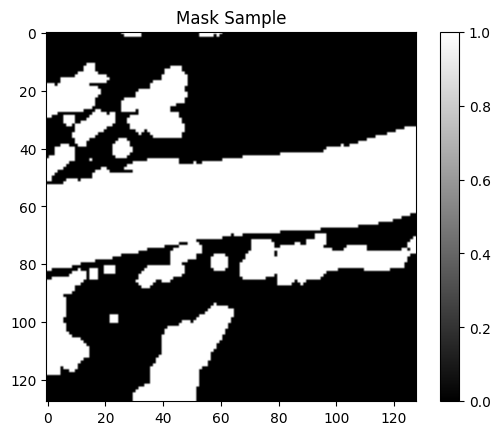

In [14]:
import matplotlib.pyplot as plt

idx = np.random.randint(0, len(Y_train))  # Pick a random sample
plt.imshow(Y_train[idx], cmap="gray")
plt.title("Mask Sample")
plt.colorbar()
plt.show()


In [3]:
# Create and compile the model
model = unet_model(input_shape=(128, 128, 12), learning_rate=0.0001)

# Define training parameters
batch_size = 8
epochs = 50

# Train the model
history = model.fit(
    X_train, Y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=[IoUCallback()],
    verbose=1
)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - iou_metric: 0.3692 - loss: 0.5702
Epoch 1: IoU = 0.4187
31/31 ━━━━━━━━━━━━━━━━━━━━ 44s 669ms/step - iou_metric: 0.3708 - loss: 0.5676 - val_iou_metric: 0.2794 - val_loss: 0.3643
Epoch 2/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - iou_metric: 0.4954 - loss: 0.3509
Epoch 2: IoU = 0.4859
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - iou_metric: 0.4948 - loss: 0.3510 - val_iou_metric: 0.3264 - val_loss: 0.3358
Epoch 3/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - iou_metric: 0.5296 - loss: 0.3364
Epoch 3: IoU = 0.4841
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - iou_metric: 0.5268 - loss: 0.3383 - val_iou_metric: 0.3552 - val_loss: 0.3164
Epoch 4/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - iou_metric: 0.4928 - loss: 0.3212
Epoch 4: IoU = 0.4860
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - iou_metric: 0.4923 - loss: 0.3216 - val_iou_metric: 0.3976 - val_loss: 0.2854
Epoch 5/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - iou_metric: 0.5067 - loss: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


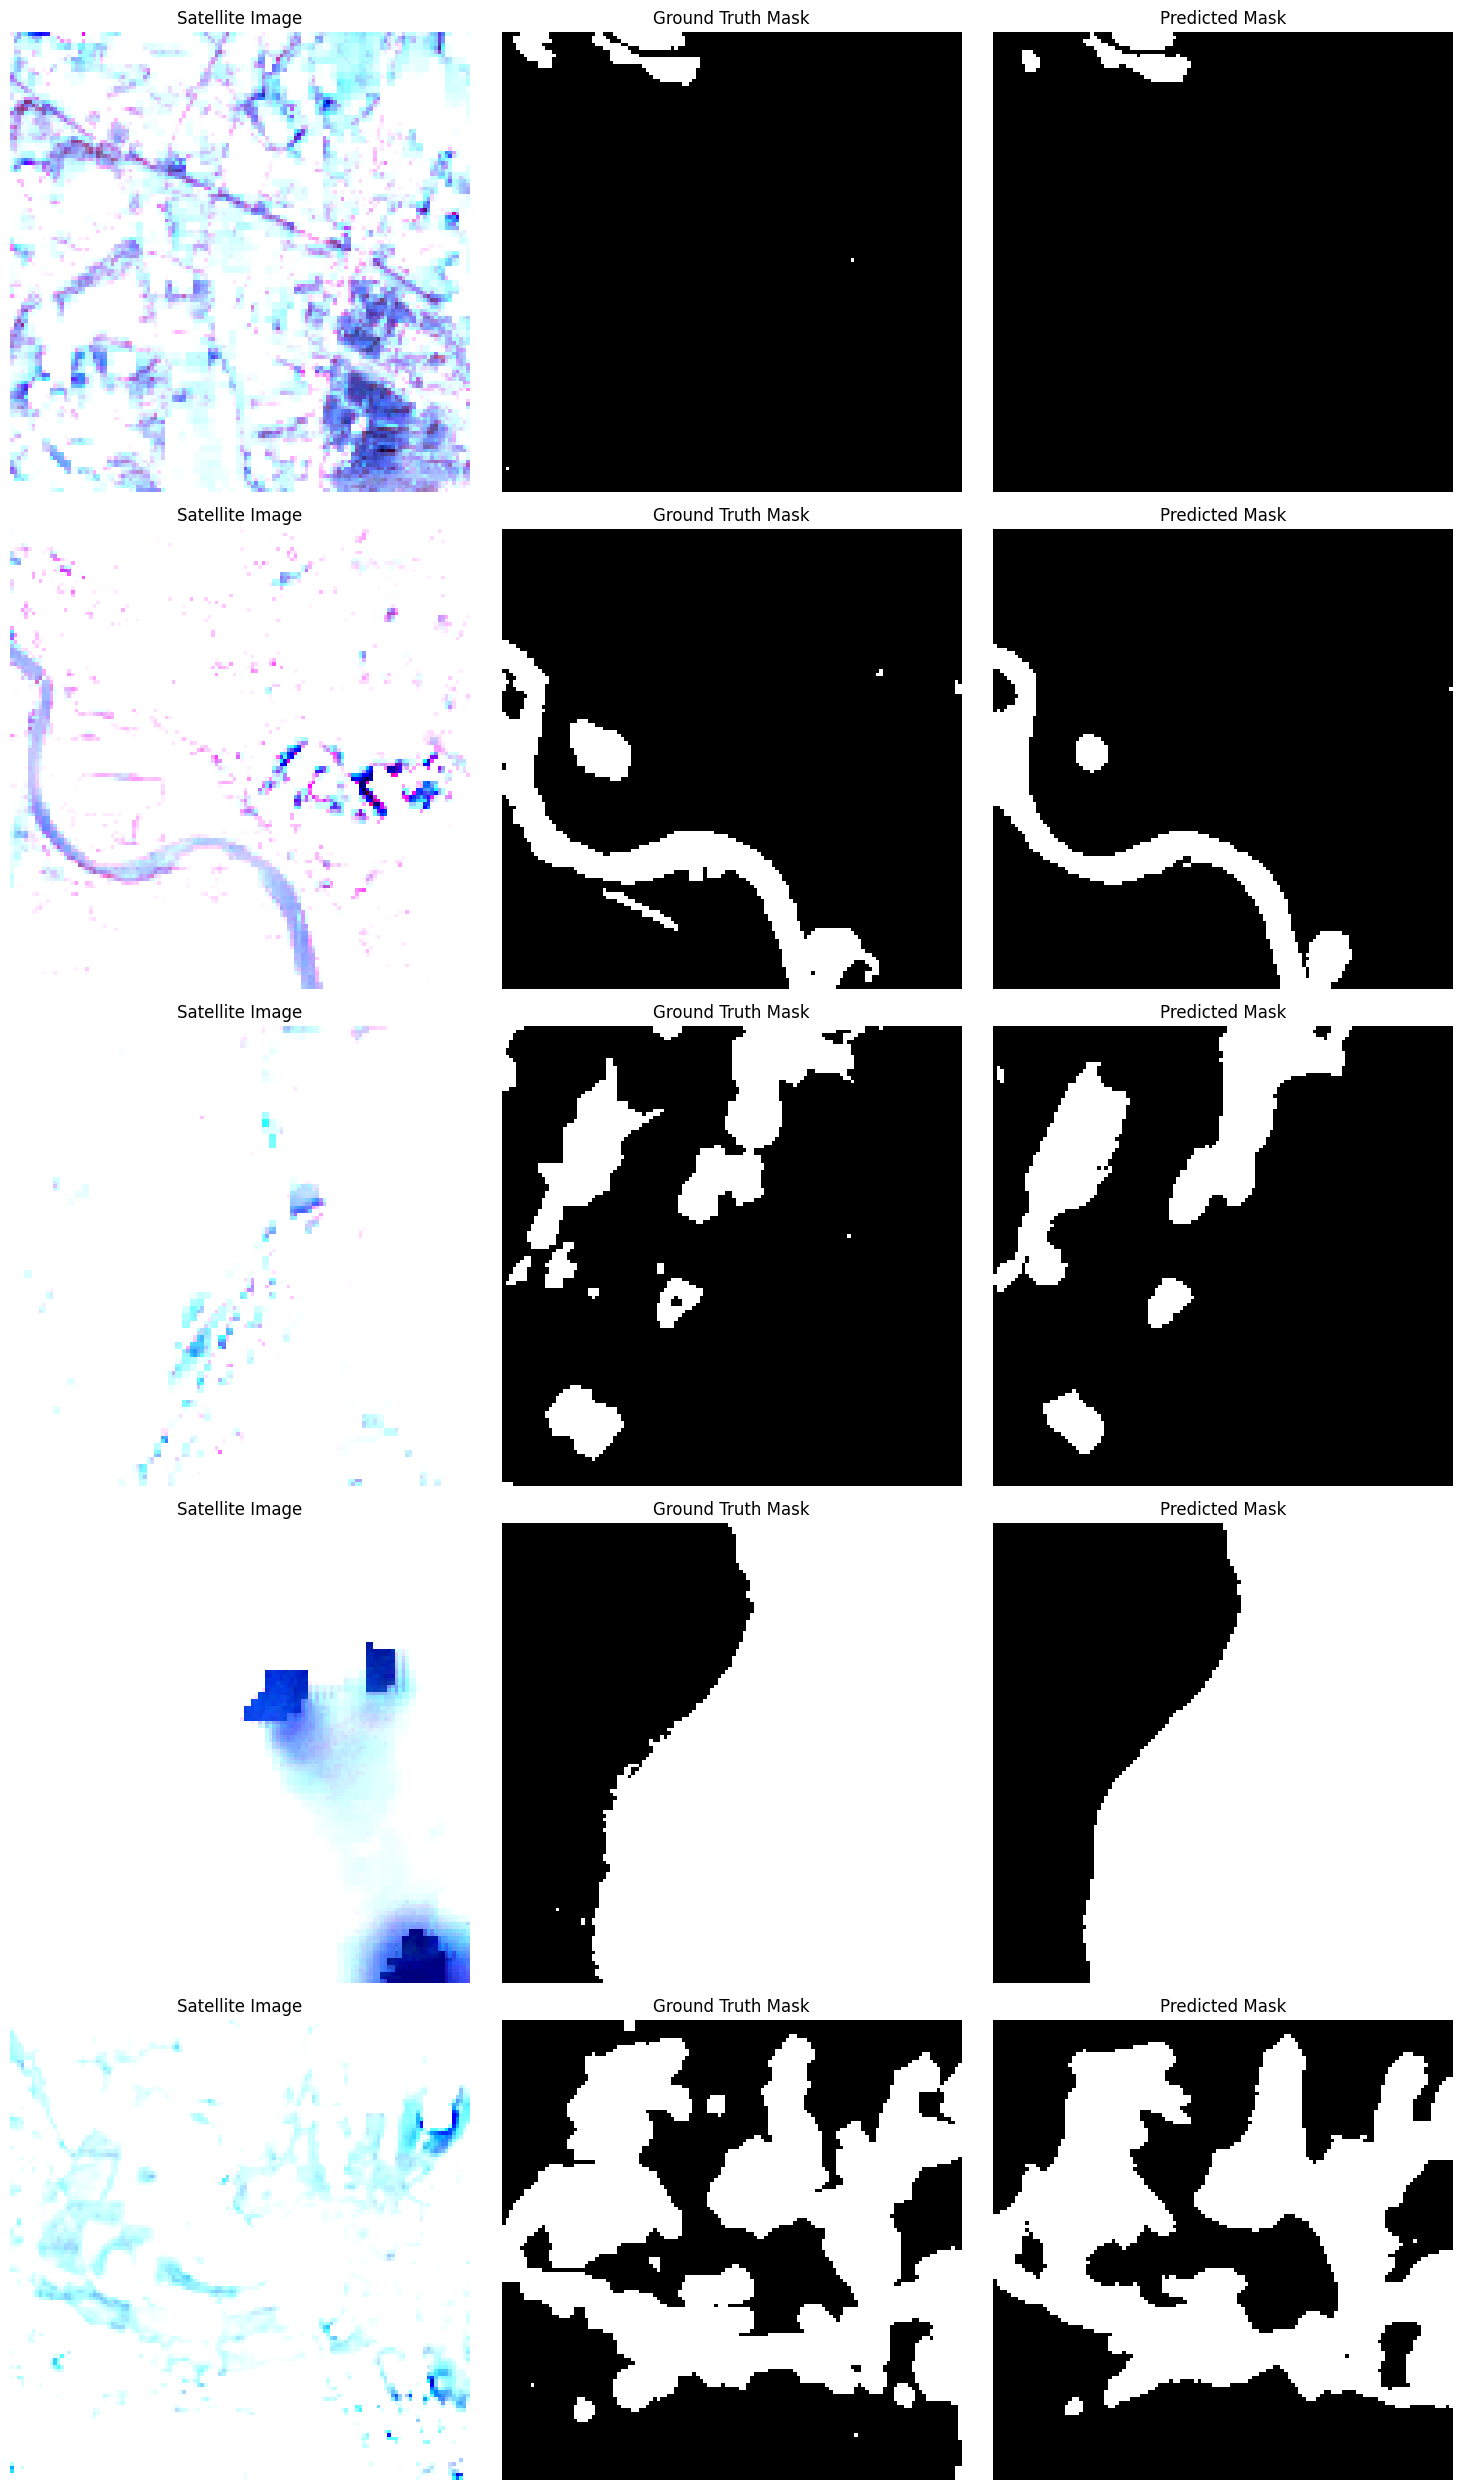

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def show_predictions(model, X, Y, num_samples=5, threshold=0.5):
    indices = np.random.choice(len(X), num_samples, replace=False)
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

    for i, idx in enumerate(indices):
        image = X[idx]
        true_mask = Y[idx]

        # Predict flood mask using the trained model
        pred_mask = model.predict(image[np.newaxis, ...])  # Add batch dimension
        pred_mask = pred_mask.squeeze()  # Remove extra dimensions

        # Threshold to get binary mask (if needed)
        pred_mask = (pred_mask > threshold).astype(np.uint8)

        # Show satellite image
        axes[i, 0].imshow(image[:, :, :3])  # First 3 channels as RGB
        axes[i, 0].set_title("Satellite Image")
        axes[i, 0].axis("off")

        # Show ground truth mask
        axes[i, 1].imshow(true_mask.squeeze(), cmap="gray")
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis("off")

        # Show predicted mask
        axes[i, 2].imshow(pred_mask, cmap="gray")
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

# Call function
show_predictions(model, X_train, Y_train)


In [4]:
# Make predictions
Y_pred = model.predict(X_train, batch_size=8)  # Predict for all images

# Threshold predictions to convert them into binary masks (0 or 1)
Y_pred_binary = (Y_pred > 0.5).astype(np.uint8)

# Function to compute IoU for all images collectively
def compute_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    iou = intersection / (union + 1e-6)  # Adding a small value to avoid division by zero
    return iou

# Compute IoU for all images collectively
iou_score = compute_iou(Y_train, Y_pred_binary)
print(f"Overall IoU for all images: {iou_score:.4f}")


39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step
Overall IoU for all images: 0.8390
